# Modeling, sampling, confidence intervals

## Recommended reading

* http://statsthinking21.org/index.html
Chapters 7,8

* Glover, Jenkins and Doney: Section 2.7 - The central limit theorem

* Emery and Thomson: Confidence intervals, 3.8.1, 3.8.2 – Confidence interval for mean

## Probability Density Function (PDF) review with example data set

### Probability density function

$N$ = 10623 anchovy weight samples

$\Delta x$ = 5 g

**Review**: How to calculate PDF from counts, N and $\Delta x$?

* With the histogram we have the following information: counts, bin width ( $\Delta x$ = 5g), $N$ (samples).  

PDF = fraction/$\Delta x$  = counts/($N \Delta x$)

![Trawl_Life_Hist_Samp_Data](images/Trawl_Life_Hist_Samp_Data.png) 

### NOAA SWFSC - Trawl Life History Specimen Data 

fishery independent trawl surveys of coastal pelagic species

Surveys: 2003-2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets
from scipy.stats import norm, mode
from scipy import stats

species_name = 'Engraulis mordax'
file_name = 'data/trawl_swfsc/FRDCPSTrawlLHSpecimen_8b4e_b841_9c81.nc'

def read_trawl_data_file(species_name, file_name):
    
    # open the netcdf file and read in the weight and length data
    ds = nc4.Dataset(file_name)
    name = ds.variables['scientific_name'][:]
    weight = ds.variables['weight'][:]
    length = ds.variables['standard_length'][:]
    ds.close()
    
    # subset to the particular species and remove the nan values
    indices = np.logical_and(name==species_name, length<4000)
    indices = np.logical_and(indices,~np.isnan(weight))
    weight = weight[indices]
    length = length[indices]
    
    return(weight,length)

def plot_weight_histogram(species_name, normalize_pdf = True, remove_mean = False):
    
    #species_name = 'Engraulis mordax'

    # read in the weight data using 
    weight, _ = read_trawl_data_file(species_name, file_name)
    
    fig = plt.figure()
    
    bins = np.arange(0,65,5)

    if remove_mean == True:
        weight = weight - np.mean(weight)
        bins = bins - np.mean(weight)

    if normalize_pdf:
        plt.hist(weight, density=True, bins=bins)
        plt.ylabel('PDF')
    else:
        plt.hist(weight, density=False, bins=bins)
        plt.ylabel('counts')
        
    plt.title(species_name+', $\mu$ = '+'{:.2f}'.format(np.mean(weight))
              +', $\sigma$ = '+'{:.2f}'.format(np.std(weight))
              +', N = '+str(len(weight)))
    plt.xlabel('weight [g]');
    

def subsample_weights(weights, N, seed=None):
    np.random.seed(seed)
    indices = np.random.randint(0, np.size(weights), N)
    subsample = weights[indices]
    return(subsample)

def plot_subsampled_weight_histogram(species_name, N=100):
    
    #species_name = 'Engraulis mordax'

    # read in the weight data using 
    weight, _ = read_trawl_data_file(species_name, file_name)
    
    subsampled_weights = subsample_weights(weight, N)
    
    fig = plt.figure()
    plt.hist(subsampled_weights,density=True, bins=np.arange(0,60,5))
    plt.title(species_name+', $\\bar{x}$ = '+'{:.2f}'.format(np.mean(subsampled_weights))
              +', s = '+'{:.2f}'.format(np.std(subsampled_weights))
              +', N = '+str(len(subsampled_weights)))
    plt.xlabel('weight [g]')
    plt.ylabel('PDF');

def plot_length_vs_weight_data_with_fit(species_name, N):
    
    #species_name = 'Engraulis mordax'
    #species_name = 'Icichthys lockingtoni'

    # read in the weight data using 
    weight, length = read_trawl_data_file(species_name, file_name)
    
    z = np.polyfit(length,weight,N)
    p = np.poly1d(z)
    
    x = np.arange(np.min(length),np.max(length)+1)
    RMSE = np.sqrt(np.mean((weight-p(length))**2))
    
    fig = plt.figure()
    plt.plot(length,weight,'.')
    plt.plot(x,p(x),'-',linewidth=2)
    
    if species_name == 'Engraulis mordax':
        plt.xlim([15,190])
        plt.ylim([-20,70])
        
    plt.xlabel('standard length (mm)')
    plt.ylabel('weight [g]')
    plt.grid(alpha=0.4,linestyle='--',linewidth='0.8')
    plt.title('Model fit with '+str(N)+' polynomial term(s), RMSE = '+'{:.2f}'.format(RMSE)+' g');
    

def plot_distribution_of_subsampled_weight_means(species_name, N, n_subsamples):

    # read in the weight data using 
    weight, _ = read_trawl_data_file(species_name, file_name)
    
    sample_means = []
    for n in range(n_subsamples):
        subsampled_weights = subsample_weights(weight, N)
        sample_means.append(np.mean(subsampled_weights))
    
    fig = plt.figure(figsize = (8, 5))
    
    plt.subplot(1,2,1)
    plt.hist(sample_means, density=True, bins=np.arange(0,60,0.5))
    plt.title('a) Distribution\n of means ($\\bar{x}$)')
    x = np.arange(0,60,0.1)
    plt.plot(x, norm.pdf(x, np.mean(weight), np.std(weight)/np.sqrt(N)))
    plt.ylabel('PDF')
    plt.gca().set_ylim([0,0.5])
    plt.xlabel('weight [g]')
    yl = plt.ylim()
    
    plt.text(25,0.8*np.diff(yl), '$\mu $ = '+'{:.3f}'.format(np.mean(weight)))
    plt.text(25,0.74*np.diff(yl), '$\sigma/\sqrt{N} $ = '+'{:.3f}'.format(np.std(weight)/np.sqrt(N)))
    plt.text(25,0.5*np.diff(yl), 'Mean of $\\bar{x}$\n = '+'{:.3f}'.format(np.mean(sample_means)))
    plt.text(25,0.36*np.diff(yl), 'Std. Dev. of\n $\\bar{x}$ = '+'{:.3f}'.format(np.std(sample_means)))
    
    plt.subplot(1,2,2)
    plt.title('b) Same as a), but zoomed in')
    x = np.arange(10,20.1,0.1)
    plt.hist(sample_means, density=True, bins=np.arange(0,60,0.5))
    plt.plot(x, norm.pdf(x, np.mean(weight), np.std(weight)/np.sqrt(N)))
    plt.xlabel('weight [g]')
    plt.gca().set_ylim([0, 0.5])
    plt.gca().set_xlim([10, 20]);


### Subsampled data set

If we think of the above PDF as repesenting the total poulation of *Engraulis mordax* in the whole ocean, then you can think of the subsample as a result you might get if you just went out and trawled for one day.

Click the button to generate a random set of $N$ subsamples from the larger dataset.

In [2]:
my_interact_manual = interact_manual.options(manual_name="create sub-sample")

im = my_interact_manual(plot_subsampled_weight_histogram, 
            species_name = fixed(species_name),
            N=IntSlider(min=10, max=1000, step=10, value=100),
            seed=None);

display(im);


interactive(children=(IntSlider(value=100, description='N', max=1000, min=10, step=10), Button(description='cr…

<function __main__.plot_subsampled_weight_histogram(species_name, N=100)>


$N$ = 100 anchovy weight samples

What are the key differences, similarities of this distribution, compared with all 10623 samples?

- *differences*: a pdf of smaller sample sizes are noiser, less smooth.  May see more variability from one bin to the next.

- *similarities*: theoretical distribution resembles poisson distribution (skewed data set with a longer tail), scale of y-axis (normalized by the bin width so magnitudes of different data sets are comparable)

### Statistical modeling
#### What is a model? 

Physical models (e.g., of a building, of Monterey Bay, of a cell or a molecule) represent something on a different scale to make it easier to understand. They convey the essence of something without having to worry about all the details. A statistical model is same basic idea as a physical model, we want to convey the essence of the dataset without having to use an entire dataset

#### Basic structure of a statistical model

A statistical model is based off data. Error is an inherent part of of any model prediction. One of the key goals in evaluating a model is to quantify that error. 

data = model + error

$x_i = \hat{x}_i + \epsilon_i$

where $x_i$ is one data point, $\hat{x}_i$ is the corresponding model predition, and $\epsilon_i$ is the difference between them.

### Example data set: simplest model

#### The simplest possible model is a single value 
* Mode = 5 g

* Mean = 15.326 g

* Median = 14 g

In this case the mean is much bigger than the mode is about 15 grams (data is skewed).  A median describes the central value, or 50th percentile in the data set.

If we use the mode as the model, we can write it as:
$\hat{weight_i}$ = 5 g

The $\hat{}$ denotes a value predicted by the model

The subscript $_i$ denotes one data point with the model value, a generic observation.  For example, if we specify  $i=1$, it could mean the first row in a spreadsheet.

We can describe the error based on the model structure:
$error_i = weight_i - \hat{weight_i}$

where $weight_i$ is an observation, or data point, and $\hat{weight_i}$ is the corresponding model prediction. Each observation has a model prediction and an error associated with it. 

In the example, if we have 10623 data points, then a model will have 10263 errors.

### Example data set: mode as a model

<Figure size 640x480 with 0 Axes>

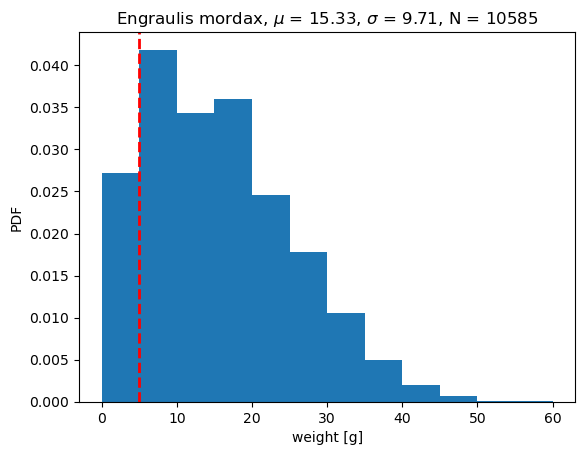

In [3]:
weight,length = read_trawl_data_file(species_name, file_name)

plt.figure()
plot_weight_histogram(species_name, normalize_pdf = True)
xl = plt.xlim()
yl = plt.ylim()
plt.plot([mode(weight)[0], mode(weight)[0]],[yl[0], yl[1]], 'r--', lw=2)
plt.xlim(xl)
plt.ylim(yl);

With this model, each model prediction has a constant value of 5 g, that is,

$\hat{x}_i$ = 5 g.

The average error, $\bar{\epsilon_i} = \overline{(x_i - \hat{x}_i)}$, when using mode as model is 10.326 g. In other words the positive errors dominate the average error.

If we use the mean as a model, would you expect the average error increase or decrease?

### Example data set: mean as a model

<Figure size 640x480 with 0 Axes>

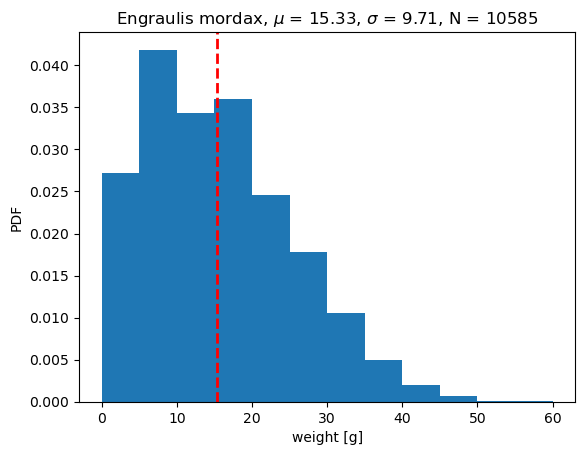

In [4]:
plt.figure()
plot_weight_histogram(species_name, normalize_pdf = True)
xl = plt.xlim()
yl = plt.ylim()
plt.plot([np.mean(weight), np.mean(weight)],[yl[0], yl[1]], 'r--', lw=2)
plt.xlim(xl)
plt.ylim(yl);



If we use the mean as a model, $\hat{x_i} = \bar{x_i}$ 

The average error when using mean as a model is 0.0g.  In this case, the negative errors cancel out the positive errors. In this case, the mean error does not do a good job of describing the distribution of errors. In fact, this metric is a measure of bias but does not say anything about the random errors (precision) of the model.

#### What other metrics can we use to quantify model error?

Some ways of quantifying the error:

We can describe the mean error (average error) as:

$ME = \frac{1}{N} \sum_{i=1}^N (x_i - \hat{x_i})$

If our model ($\hat{x_i}$) is the mean of the dataset ($\bar{x_i}$), then the ME = 0 and the model is *unbiased*.


#### Sum of Squared Errors

$SSE = \sum_{i=1}^N (x_i - \hat{x_i})^2$

(This treats the positive and negative values equally)

#### Mean Squared Error

$MSE = \frac{1}{N} SSE$

#### Root Mean Square Error 

$RMSE = \sqrt{MSE}$

The units for RMSE will make it easier to understand the error mismatch. This is a summary of all the errors in the dataset by penalizing all errors in the dataset equally. For our two models examined so far, where the model is only a constant value, the RMSE can by summarized as:

* RMSE(mean) = 9.71 grams 
* RMSE(mode) = 14.18 grams

### The mean is the single value that minimizes RMSE 

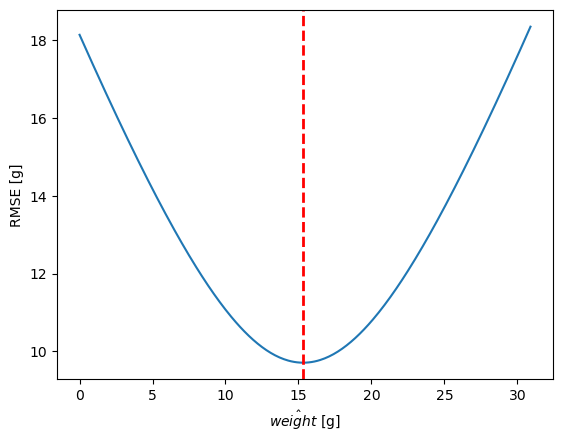

In [5]:
xmod = np.arange(0,31,0.1)
xsae = np.nan*np.zeros(len(xmod))

for i,xmodi in enumerate(xmod):
    xsae[i] = np.sqrt(np.mean((weight-xmodi)**2))
    
plt.figure()
plt.plot(xmod,xsae)
plt.xlabel('$\hat{weight}$ [g]')
plt.ylabel('RMSE [g]')

xl = plt.xlim()
yl = plt.ylim()
plt.plot([np.mean(weight), np.mean(weight)],[yl[0], yl[1]], 'r--', lw=2)
plt.xlim(xl)
plt.ylim(yl);

* This plot is showing the RMSE as a function of the model value. 

* This plot is an example of what is called a *cost function*. We have a model parameter on the x-axis and an error, or "cost" on the y-axis.  In modeling we are often interested in the parameter that minimizes the cost function.

* The vertical dashed line shows the mean value. Out of all possible models defined by a single parameter, the mean is the one the minimizes the RMSE and would be considered most optimal.

### A simple model with two parameters: linear model 

Let's say that we want to model fish weight as a function of length for this species. This might be useful in a case where length estimates are common, but weight estimates are more labor-inetensive. Or maybe there is interest in comparine length-weight relationships for different species.

/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_28378/744610339.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  err = dfsub['weight']-(results.params[0]+results.params[1]*dfsub['standard_length'])
/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_28378/744610339.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]+results.params[1]*dfsub['standard_length'],


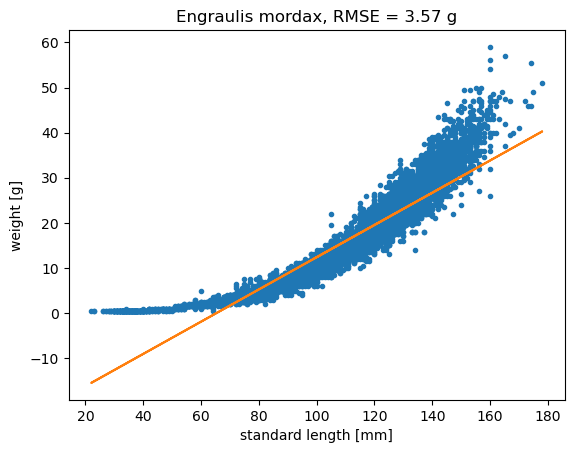

In [6]:
import xarray as xr
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# load dataset and convert to Pandas dataframe
ds = xr.open_dataset('data/trawl_swfsc/FRDCPSTrawlLHSpecimen_8b4e_b841_9c81.nc')
df = ds.to_dataframe()
dfsub = df.loc[(df['scientific_name'] == 'Engraulis mordax') & 
               (ds['standard_length'].values < 1e8)]

# linear fit with statsmodels package
results = smf.ols('weight ~ 1 + standard_length', dfsub).fit()

# RMSE
err = dfsub['weight']-(results.params[0]+results.params[1]*dfsub['standard_length'])
rmse = np.sqrt(np.mean(err**2))

# plot linear model
plt.figure()
plt.plot(dfsub['standard_length'],dfsub['weight'],'.')
plt.plot(dfsub['standard_length'],
         results.params[0]+results.params[1]*dfsub['standard_length'],
         '-')
plt.xlabel('standard length [mm]')
plt.ylabel('weight [g]')
plt.title('Engraulis mordax, RMSE = '+str(np.round(rmse,2))+ ' g');

The linear model has RMSE = 3.57 g

Looking at the data, it looks like a linear model only works for part of the data. It tends to be biased low at the smallest and largest length values.  If we were going to use this linear model, our equation would be: 

$\hat{weight_i} =  constant + a * length_i$

The $\hat{}$ symbol indicates $\hat{weight_i}$ is a model

Here the $constant$ is the intercept and $a$ is the slope.

The intercept and slope are the model parameters. You can think of the error $\epsilon_i$ for each data point as being the vertical distance between the data point and the model, $x_i - \hat{x}_i$.

### Example data set: quadratic model 

/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_28378/2931778582.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  errq = dfsub['weight']-(resultsq.params[0]+
/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_28378/2931778582.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resultsq.params[1]*dfsub['standard_length']+
/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_28378/2931778582.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

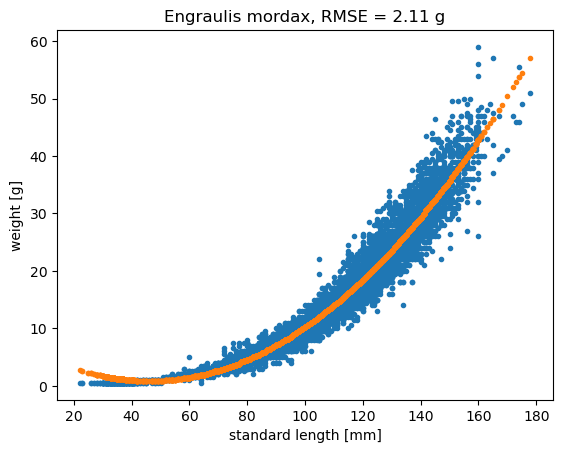

In [7]:
resultsq = smf.ols('weight ~ 1 + standard_length + I(standard_length**2)', dfsub).fit()

errq = dfsub['weight']-(resultsq.params[0]+
         resultsq.params[1]*dfsub['standard_length']+
         resultsq.params[2]*dfsub['standard_length']**2)
rmseq = np.sqrt(np.mean(errq**2))

plt.figure()
plt.plot(dfsub['standard_length'],dfsub['weight'],'.')
plt.plot(dfsub['standard_length'],
         resultsq.params[0]+
         resultsq.params[1]*dfsub['standard_length']+
         resultsq.params[2]*dfsub['standard_length']**2,
         '.')
plt.xlabel('standard length [mm]')
plt.ylabel('weight [g]')
plt.title('Engraulis mordax, RMSE = '+str(np.round(rmseq,2))+ ' g');

The quadratic model has RMSE = 2.11 g. 

$\hat{weight_i} =  constant + a * length_i + b * length_i^2$

The constant, a, and b are model parameters that describe the structure or the shape of the model. We can find the model that minimizes the RMSE.  This looks like it is doing better than a linear model, but the model indicates that their weight decreases as they get bigger for smaller fish.  It still has some systematic errors where there is some bias.

### Example data set: data transformation

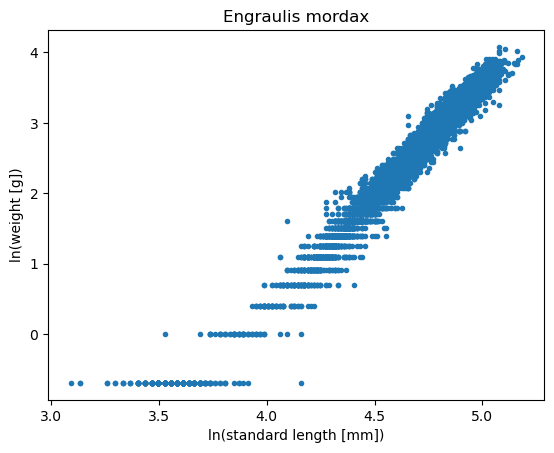

In [8]:
plt.figure()
plt.plot(np.log(dfsub['standard_length']),
         np.log(dfsub['weight']),'.')
plt.xlabel('ln(standard length [mm])')
plt.ylabel('ln(weight [g])')
plt.title('Engraulis mordax');

This is the same data transformed to a logarithmic scale, and now it appears that a linear model may be appropriate.  Now, we are not minimizing the RMSE, you are minimizing the logarthmic RMSE.

#### What makes a model good?

- good fit
- minimizes error
- represents actual scenario of the data 
- is not overcomplicated

### Modeling another species - Overfitting

Overfitting occurs when a model is overcomplicated and not representative of the actual scenario. If we add more parameters by adding more terms to the polynomial model equation, we may get an unrealistic model with a low RMSE. Symptoms of overfitting include large swings in model curves where no data points exist.

If another datapoint is added without readjusting the model (for example, if a *Icichthys lockingtoni* specimen with 150 mm length were caught), the RMSE will likely be large.  

Datasets with large sample sizes are still prone to overfitting. Even with many data points, a model for *Engraulis mordax* with many coefficients is overly sensitive to the extreme data values. 

In [9]:
interact(plot_length_vs_weight_data_with_fit,
        species_name = ['Icichthys lockingtoni', 'Engraulis mordax'],
         N=widgets.IntSlider(min=0, max=10, step=1, value=7));

interactive(children=(Dropdown(description='species_name', options=('Icichthys lockingtoni', 'Engraulis mordax…

### Sampling
* *Statistical inference*: One of the foundational ideas in statistics is that we can make inferences about an entire population based on a relatively small sample of individuals from that population.

* *Goal of sampling*: determine the value of a statistic for an entire population of interest, using just a small subset of the population.

The way in which we select the sample is critical to ensuring that the sample is representative of the entire population.

Adapted from: http://statsthinking21.org/sampling.html

### Back to the anchovy data example: distribution of means

![trawl_pdf_mean_dist](images/trawl_pdf_mean_dist.png)

**Blue bars**: distribution of 1000 different sample means ($\bar{x}$), with N = 100 samples each 

Mean of $\bar{x}$ = 15.346 g
Std. dev. of $\bar{x}$ = 0.933 g

**Orange curve**: normal distribution 
  
$\mu$ = 15.327 g (mean of full data set)

$\frac{\sigma}{\sqrt{N}}$ = 0.971 g (std. dev. of full data set / √100)
      
      

### Anchovy data: distribution of means (zoomed in)

![images/trawl_pdf_mean_dist_zoomed.png](images/trawl_pdf_mean_dist_zoomed.png)


#### Blue bars: distribution of 106 different sample means ($\bar{x}$), with N = 100 samples each 

Mean of $\bar{x}$ = 15.358 g
Std. dev. of $\bar{x}$ = 0.822 g

#### Orange curve: normal distribution 
  
$\mu{}$ = 15.327 g (mean of full data set)

$\frac{\sigma}{\sqrt{N}}$ = 0.971 g (std. dev. of full data set / √100)

This is a consequence of the central limit theorem.

In [10]:
interact(plot_distribution_of_subsampled_weight_means,
        species_name = fixed(species_name),
        N = widgets.IntSlider(min=1, max=100, step=1, value=3),
        n_subsamples = widgets.IntSlider(min=10, max=1000, step=20, value=1000))

interactive(children=(IntSlider(value=3, description='N', min=1), IntSlider(value=1000, description='n_subsamp…

<function __main__.plot_distribution_of_subsampled_weight_means(species_name, N, n_subsamples)>

## The Central Limit Theorem

The __central limit theorem__ states that no matter what the probability distribution of parent population is, the _mean of the means_ drawn from the same population is normally distributed for large sample sizes. As $N$ approaches infinity,

mean $(\bar{x}) \rightarrow \mu$ (the mean of the sample means approaches the true mean)

std $(\bar{x}) \rightarrow \frac{\sigma}{\sqrt{N}}$ (the standard deviation of the sample means approaches the true standard error)

The important consequence of this theorem is that if you collect enough samples, the sample mean will always provide an unbiased estimate of the true mean and you can calculate confidence intervals with the formulas above.

However, if you have too few samples, the sample mean will provide a _biased_ estimate.

Some examples of situation where the central limit theorem is applied:

* Radiochemists study discrete decay events, which follow a Poisson distribution. A few samples will give a biased estimate of the mean rate of radioactive decay. If enough samples are collected, the sample mean and 95% confidence intervals can be calculated using the formulas described above.


* Physical oceanographers routinely take advantage of the central limit theorem when using observations of pressure or velocity measurements to study processes with time scales much longer than individual waves. The probability distribution of a wavy sea surface is not normal at all, but by collecting many samples (a.k.a. an "ensemble") over a period of ~10-20 minutes the waves are effectively "averaged out" and one can be reasonably confident in the mean of that ensemble. 

When sampling a noisy environment and ensemble averaging, oceanographers must be careful to choose an ensemble that is long enough to collect enough samples, but not so long that the statistics are changing significantly over longer time scales. If statistics are robust regardless, of the sampling duration, the process is said to be __stationary__. 

\*Adapted from: http://statsthinking21.org/sampling.html



### Central limit theorem (in other words)

The distribution of an average tends to be Normal, even when the distribution from which the average is computed is decidedly non-Normal. 

http://www.statisticalengineering.com/central_limit_theorem.htm

The amazing and counter-intuitive thing about the central limit theorem is that no matter what the shape of the original distribution, the sampling distribution of the mean approaches a normal distribution. Furthermore, for most distributions, a normal distribution is approached very quickly as N increases. 

http://davidmlane.com/hyperstat/A14043.html

### Central limit theorem - applications

The weight distribution of *Engraulis mordax* is skewed. However, if we have hundreds of samples, the 95% confidence interval for the mean can still be estimated as

$\bar{x}$ ±1.96 $\frac{s}{\sqrt{N}}$

With very few samples, the mean would not only be uncertain, but also biased.

<!---### Central limit theorem – dice example

If we start to get more samples, we start to get more of a peak in the distribution

![images/clt_dice_ex.png](images/clt_dice_ex.png)-->


### The *z* Distribution

<!--![images/zdist_example.png](images/zdist_example.png)-->

* According to the central limit theorem, sample means ($\bar{x}$) are normally distributed for large N.  
* This gives you data that is standardized in a way that if we take  z-scores of the sample means ($\bar{x}$),  95% of them should fall in the range:

		-1.96 < z < 1.96
        
* This is the basis for forming 95% confidence intervals        


![images/trawl_pdf_mean_dist_zoomed.png](images/trawl_pdf_mean_dist_zoomed.png)

### Confidence intervals for the mean

$CI_{95\%} = \bar{x} \pm 1.96 \times SE$, where SE is the standard error $\frac{S}{\sqrt{N}}$

With large enough sampling size N, the 95% confidence interval will contain the true population mean 95% of the time. Here 1.96 is a critical z-score. In theory, if a population is normally distributed then 95% of the z-scores will be between -1.96 and 1.96. 

This equation is only valid for large samples sizes. For small sample sizes, we use a t-distribution instead of z-distribution (covered later).

#### Example: fish weight distribution

The plot below shows 95% confidence intervals for the mean for different subsets that are randomly selected from the main dataset. The default plot shows results from 100 trials (you can think of this as doing 100 trawls) where $N$ = 10 samples are collected in each trial. The population mean (or true mean) estimated from the larger dataset is shown in blue. This is a fixed parameter and does not change.

The confidence intervals generally encompass the population mean. However, there are some trials where the confidence intervals fail. Also, by making the sample size small (e.g. $N$ = 3) you can see that the confidence intervals start to encompass negative values, which is not realistic for this data set. 


In [11]:
ntrial = 1000

xm = np.nan*np.zeros(ntrial)
xs = np.nan*np.zeros(ntrial)
xci_lower = np.nan*np.zeros(ntrial)
xci_upper = np.nan*np.zeros(ntrial)

ii = (ds['scientific_name'] == 'Engraulis mordax') & (ds['standard_length'] < 1e8)


xmean = np.mean(ds['weight'][ii])
xstd = np.std(ds['weight'][ii],ddof=1)
xSE = xstd/np.sqrt(100)

def plot_confidence_intervals(N, ntrial):
    cnt = 0 
    for i in np.arange(ntrial):
        subi = np.random.randint(0, len(ds['weight'][ii]), N)
        xm[i] = np.mean(ds['weight'][ii][subi])
        xs[i] = np.std(ds['weight'][ii][subi], ddof=1)
        (lower,upper) = stats.t.interval(0.95, N-1, loc=xm[i], scale=xs[i]/np.sqrt(N))
        xci_lower[i] = lower
        xci_upper[i] = upper
        #xci_lower[i] = xm[i]-1.96*xs[i]/np.sqrt(N)
        #xci_upper[i] = xm[i]+1.96*xs[i]/np.sqrt(N)
        if (xmean >= xci_lower[i]) & (xmean < xci_upper[i]):
            cnt = cnt + 1

    plt.figure(figsize=(5,5))

    for j in np.arange(0,ntrial):
        if (xmean >= xci_lower[j]) & (xmean < xci_upper[j]):
            plt.plot([xci_lower[j], xci_upper[j]], [j,j], 'k-')
        else:
            plt.plot([xci_lower[j], xci_upper[j]], [j,j], 'r-')

    yl = plt.ylim()
    plt.plot([xmean,xmean], yl, 'b--')
    plt.ylim(yl)
    plt.title('95% confidence intervals\nrandom subsets with N = ' + str(N))
    plt.xlabel('weight [g]')
    plt.ylabel('trial #')
    plt.xlim([-10, 50]);

interact(plot_confidence_intervals,
         N=widgets.IntSlider(min=5, max=100, step=1, value=10),
         ntrial=widgets.IntSlider(min=10, max=200, step=1, value=100));

interactive(children=(IntSlider(value=10, description='N', min=5), IntSlider(value=100, description='ntrial', …



#### Common misinterpretation of confidence intervals*:

“There is a 95% chance that the population mean falls within the interval.”

What is wrong with this statement, and how does it differ from the correct interpretation?
* In the case of confidence intervals, we can't interpret them in this way because the population parameter has a fixed value -  it is or it isn't in the interval

* It is the *sample mean* that has a probability of falling within the confidence intervals, not the *true mean* or *population mean* 

* Confidence intervals treat the parameter as fixed (it has one *true* value) and the interval as variable (it will change based on the subset of data actually collected). 


\*Adapted from: http://statsthinking21.org/sampling.html
